In [111]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
M = 100 # Order of poly is M-1
from random import randint as rand
with open("non_gaussian.csv", 'r') as f:
    data = list(csv.reader(f,delimiter = ','))


def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=5000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    for i in range(parts):
        phii = np.delete(phix,alls[i],axis = 0)
        ti = np.delete(tx,alls[i])
        if(pinv):
            wi,hi = MPPI(phii,ti,m,lamda)   
            costi = SSE(hi,ti)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        # Wi and Hi are weights and hypothesis values at all inputs in this training set
        hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
        training_error += costi # Increment total training error
        test_error += SSE(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    test_error = math.sqrt(test_error)
    training_error = math.sqrt(training_error)
    print(test_error,training_error)
    return test_error,training_error

In [112]:
# data= data[0:20]
data = np.array(data)
data = np.array([[float(d[0]),float(d[1])] for d in data])
data = data[np.argsort(data[:,0])]
x = np.array([d[0] for d in data], dtype = 'float')
t = np.array([d[1] for d in data], dtype= 'float')
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x])
N = t.size
print(data)

[[-1.6010e+00  1.2820e+01]
 [-1.5545e+00  1.9100e+01]
 [-1.5080e+00  2.3497e+01]
 [-1.4616e+00  2.9305e+01]
 [-1.4151e+00  3.0785e+01]
 [-1.3686e+00  3.4171e+01]
 [-1.3221e+00  3.3667e+01]
 [-1.2756e+00  3.1455e+01]
 [-1.2291e+00  3.3691e+01]
 [-1.1826e+00  3.1514e+01]
 [-1.1362e+00  3.1040e+01]
 [-1.0897e+00  2.7370e+01]
 [-1.0432e+00  2.5587e+01]
 [-9.9670e-01  2.3763e+01]
 [-9.5022e-01  2.4953e+01]
 [-9.0373e-01  2.0205e+01]
 [-8.5725e-01  1.9554e+01]
 [-8.1076e-01  2.0025e+01]
 [-7.6428e-01  1.6639e+01]
 [-7.1779e-01  1.6406e+01]
 [-6.7131e-01  1.2334e+01]
 [-6.2482e-01  1.2422e+01]
 [-5.7834e-01  1.1668e+01]
 [-5.3185e-01  1.4065e+01]
 [-4.8537e-01  1.1605e+01]
 [-4.3888e-01  1.1275e+01]
 [-3.9240e-01  1.2063e+01]
 [-3.4591e-01  1.2955e+01]
 [-2.9943e-01  1.0936e+01]
 [-2.5294e-01  1.1993e+01]
 [-2.0646e-01  1.2111e+01]
 [-1.5997e-01  1.3275e+01]
 [-1.1349e-01  1.3473e+01]
 [-6.7002e-02  1.2693e+01]
 [-2.0517e-02  1.3923e+01]
 [ 2.5968e-02  1.4154e+01]
 [ 7.2453e-02  1.6376e+01]
 

In [113]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, pinv = True) for i in range(2,25)]

5.781584095299585 5.009891801029355
6.046128447711506 4.8126105384337885
5.907823007075675 4.328590496938282
12.38748125904695 4.153271005091817
5.855336683020501 2.6357107248554086
23.169924462889355 2.425148110538166
3.1280332259654897 0.983124095463632
6.065514925716944 0.972126006112819
13.667860267795694 0.9649529876234706
12.667013733533 0.9550593912370551
19.24655853756556 0.9408888545950395
89.56740013636173 0.9365023595727563
142.67131722333642 0.9337018835107881
196.3302401818094 0.9302083016715694
107.75185641793614 1.0250896924248973
689.0883174154333 1.0662240684209006
557.4847708684274 2.1334519592690935
1162.2709911724567 30.043092938516736
1460.4493127608098 99.90899461529904
2160.6775629521026 107.5278441396737
4972.9217826817385 355.87365605698267
10836.086382437912 1612.2277545777745
21674.14445078478 4223.320817427983


(2, 23)


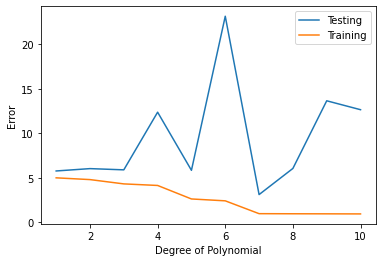

In [114]:
errs = np.copy(np.array(errors)).T
print(errs.shape)
test = errs[0][0:10]
train = errs[1][0:10]
plot_all(x = range(1,11), hs = [test,train],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error')

Choosing Optimal degree 7, i.e. M = 8

In [5]:
lamdas = [pow(10,i) for i in range(-15,1,3)]
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = lamda, m = 8, pinv = True) for lamda in lamdas]

3.1280332259654897 0.983124095463632
3.12803322722573 0.983124095463632
3.1280332368347024 0.9831240954636323
3.128042965431478 0.9831240954646534
3.1377513823371226 0.9831251145247878
5.117433893078646 1.1849940178486331


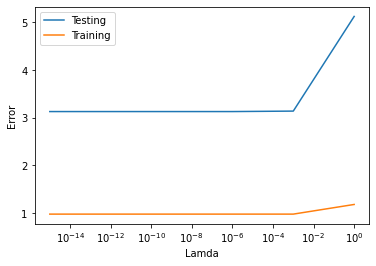

In [6]:
errs = np.array(errors).copy().T
train = errs[1][0:15]
test =errs[0][0:15]
lambs = np.copy(lamdas)
lambs = lambs[0:15]
plot_all(x = lambs, hs = [test,train], xlog = True,  legends = ['Testing','Training'], xl ='Lamda', yl ='Error',)

Hence we take the lamda as 0 since this doesn't vary

In [96]:
wx,costx = MPPI(phi  = phi,t = t, lamda = 0, m = 8)
hx = get(phi,8).dot(wx)
noises = hx - t
noises = [noise/8 for noise in noises]      # Normalising the noise from (-4,4) to (-1/2,1/2)

(array([ 2.,  3.,  4., 19., 23., 18., 24.,  7.]),
 array([-0.53407877, -0.4254186 , -0.31675842, -0.20809825, -0.09943808,
         0.00922209,  0.11788227,  0.22654244,  0.33520261]),
 <BarContainer object of 8 artists>)

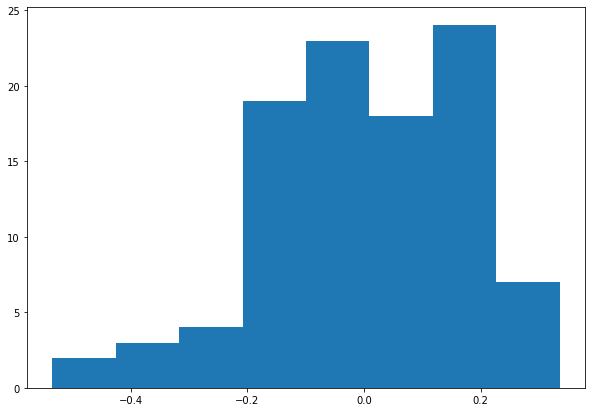

In [86]:
fig1, ax1 = plt.subplots(figsize =(10, 7))
ax1.hist(noises, bins = 'auto')

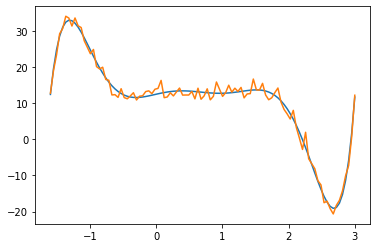

In [97]:
plt.plot(x,hx)
plt.plot(x,t)

In [ ]:
noises = np.copy(np.array(noises))


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

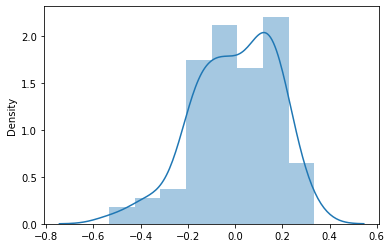

In [88]:
import seaborn as sns
import pandas as pd
sns.distplot(noises)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

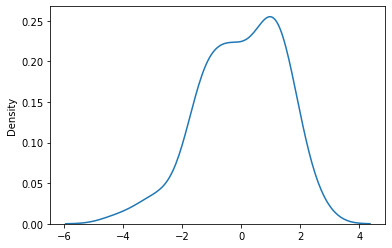

In [30]:
sns.distplot(noises, hist = False, kde = True)

Plot for alpha = 1, beta = 1


<Figure size 432x288 with 0 Axes>

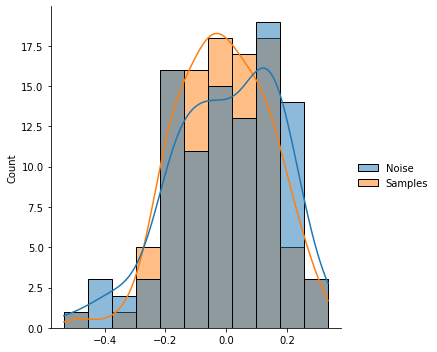

Plot for alpha = 1, beta = 2


<Figure size 432x288 with 0 Axes>

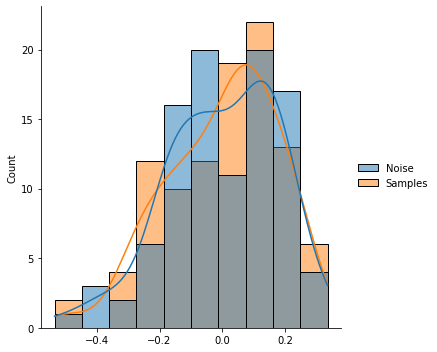

Plot for alpha = 1, beta = 3


<Figure size 432x288 with 0 Axes>

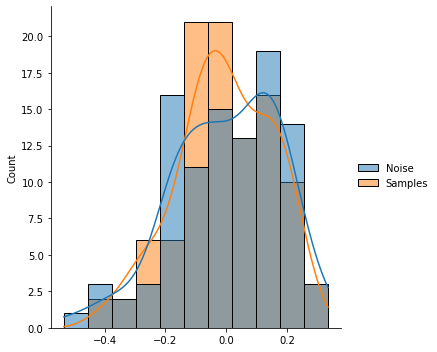

Plot for alpha = 1, beta = 4


<Figure size 432x288 with 0 Axes>

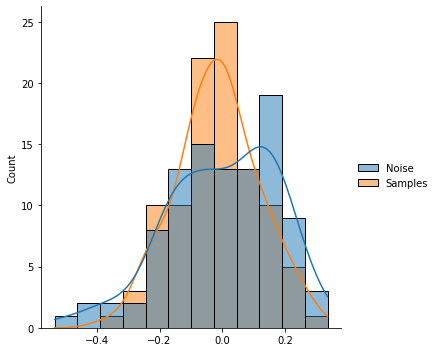

Plot for alpha = 1, beta = 5


<Figure size 432x288 with 0 Axes>

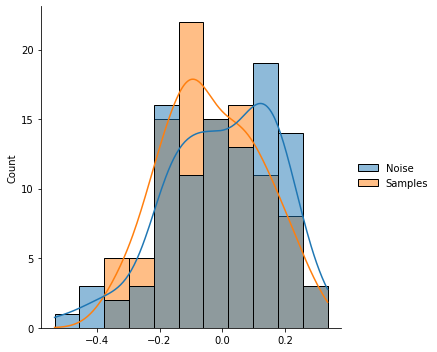

Plot for alpha = 1, beta = 6


<Figure size 432x288 with 0 Axes>

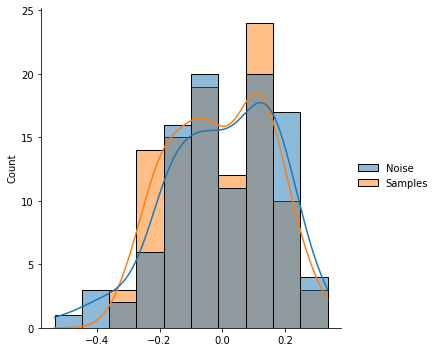

Plot for alpha = 1, beta = 7


<Figure size 432x288 with 0 Axes>

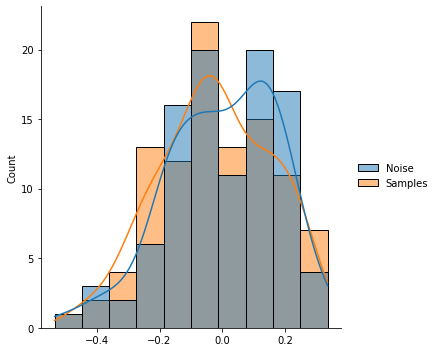

Plot for alpha = 3, beta = 3


<Figure size 432x288 with 0 Axes>

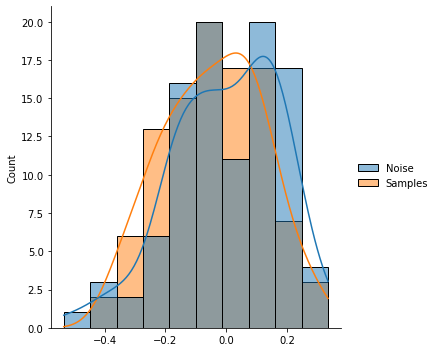

Plot for alpha = 3, beta = 4


<Figure size 432x288 with 0 Axes>

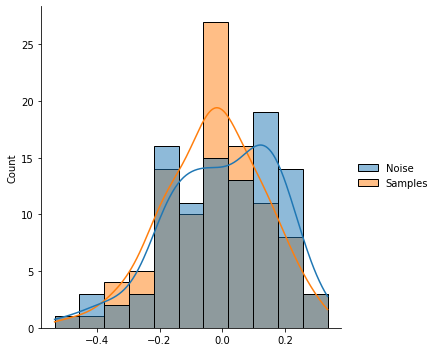

Plot for alpha = 3, beta = 5


<Figure size 432x288 with 0 Axes>

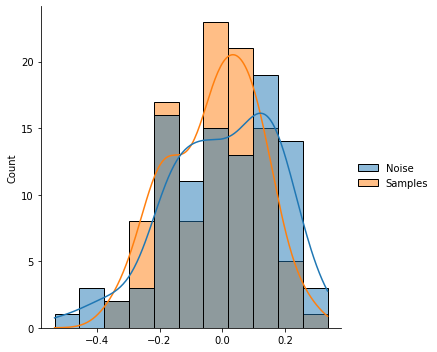

Plot for alpha = 3, beta = 6


<Figure size 432x288 with 0 Axes>

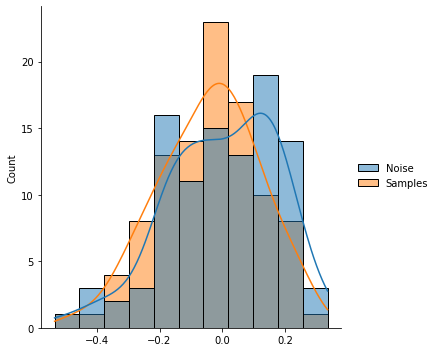

Plot for alpha = 3, beta = 7


<Figure size 432x288 with 0 Axes>

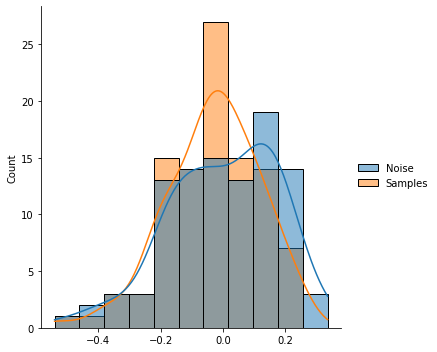

Plot for alpha = 5, beta = 5


<Figure size 432x288 with 0 Axes>

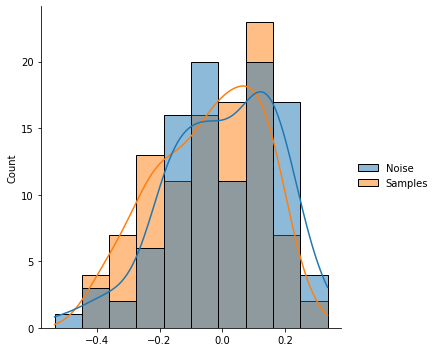

Plot for alpha = 5, beta = 6


<Figure size 432x288 with 0 Axes>

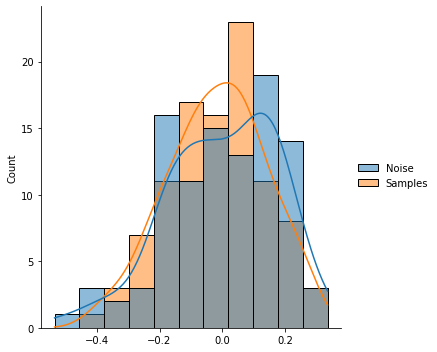

Plot for alpha = 5, beta = 7


<Figure size 432x288 with 0 Axes>

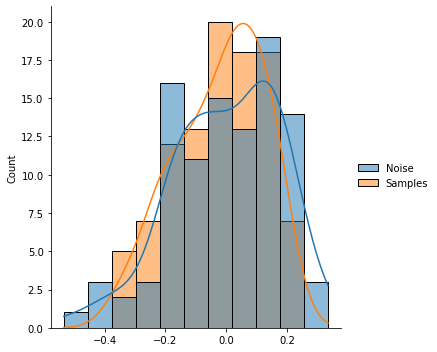

Plot for alpha = 7, beta = 7


<Figure size 432x288 with 0 Axes>

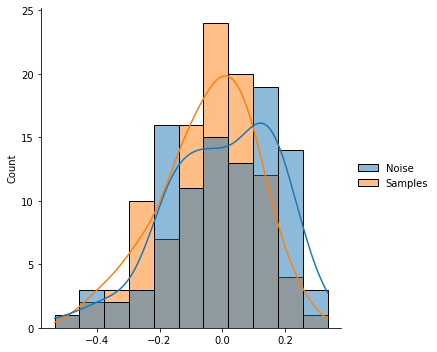

In [110]:
for al in range(1,8,2):
    for be in range(al,8):
        print("Plot for alpha = {}, beta = {}".format(al,be))
        samples = np.random.beta(5,3, size=100)
        samples = [sample - 0.65 for sample in samples]
        datas = {'Noise': noises, 'Samples' : samples}
        dfs = pd.DataFrame(datas)
        plt.figure()
        sns.displot(dfs, kde = True)
        plt.show()

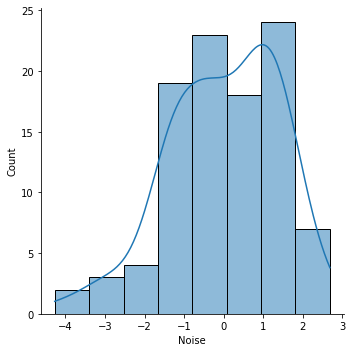

In [26]:
data1 = {'Noise': noises}
df1 = pd.DataFrame(datas)
sns.displot(df1, x="Noise",kde = True)

In [ ]:
datas = {'Samples' : samples}
dfs = pd.DataFrame(datas)
sns.displot(dfs, x="Noise",kde = True)

Plot for alpha = 0.25, beta = 0.2


<Figure size 432x288 with 0 Axes>

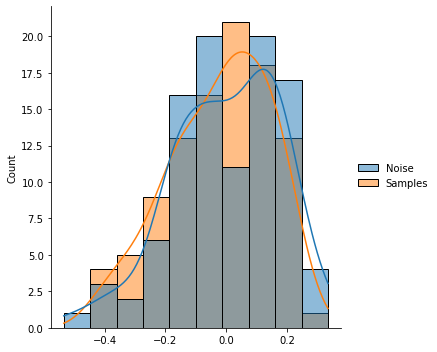

In [108]:
al = 1/4
be = 1/5
print("Plot for alpha = {}, beta = {}".format(al,be))
samples = np.random.beta(5,3, size=100)
samples = [sample - 1/2 - 0.15 for sample in samples]
datas = {'Noise': noises, 'Samples' : samples}
dfs = pd.DataFrame(datas)
plt.figure()
sns.displot(dfs, kde = True)
plt.show()